# Worked Example 1 (Case Study 1)
## ☕ Causal Data Preparation: Smoking and Tipping Behavior


## Abstract
Tipping behavior provides an excellent context to study social-behavioral causality.  
This case investigates whether being a **smoker** causes differences in **tip amounts**,  
while controlling for confounders such as total bill size, party size, day, and time of day.  
We demonstrate causal-aware preprocessing—handling missingness, encoding categorical variables,  
and estimating the Average Treatment Effect (ATE) using DoWhy.


## Theory Section
- **Treatment (T):** `smoker`
- **Outcome (Y):** `tip`
- **Confounders:** `total_bill`, `size`, `day`, `time`, `sex`
- **Causal principle:** Control for variables that jointly affect both the likelihood of smoking  
  and tipping behavior (e.g., weekend diners, party size, etc.).


## Practical Code Examples
## Causal DAG for Tips Dataset
Simplified relationships:
- `smoker → tip`
- `total_bill → tip`
- `size → total_bill`
- `day → smoker`
- `day → tip`
- `time → smoker`
- `time → tip`


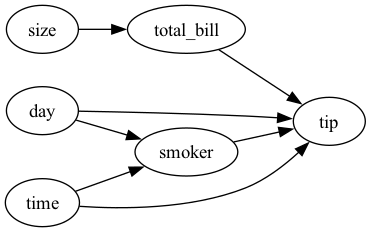

In [2]:
from graphviz import Digraph
dag = Digraph(comment="Causal DAG – Tips Dataset", format="png")
dag.attr(rankdir='LR')
dag.edge('smoker', 'tip')
dag.edge('total_bill', 'tip')
dag.edge('size', 'total_bill')
dag.edge('day', 'smoker'); dag.edge('day', 'tip')
dag.edge('time', 'smoker'); dag.edge('time', 'tip')
dag.render('tips_dag', cleanup=True)
from IPython.display import Image
Image('tips_dag.png')


In [5]:
!pip install dowhy
# or if needed:
# !pip install dowhy pygraphviz pydot



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# =========================================================
# Causal Estimation Example: Tips Dataset (Smoker -> Tip)
# =========================================================

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1) Load dataset
df = sns.load_dataset("tips").copy()

# Drop rows with missing treatment/outcome (rare)
df = df.dropna(subset=['smoker', 'tip'])

# 2) Define variables
treatment = "smoker"
outcome = "tip"
categorical = ["sex", "day", "time"]
numeric = ["total_bill", "size"]

# 3) Encode categorical features for confounders
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_cat = encoder.fit_transform(df[categorical]).toarray()
cat_names = encoder.get_feature_names_out(categorical)

# 4) Build modeling dataframe
model_df = pd.concat(
    [
        df[[outcome, treatment] + numeric].reset_index(drop=True),
        pd.DataFrame(X_cat, columns=cat_names)
    ],
    axis=1
)

# Encode treatment: Yes=1, No=0
model_df[treatment] = model_df[treatment].map({"Yes": 1, "No": 0})

# Define common causes as everything except outcome and treatment
common_causes = [c for c in model_df.columns if c not in [outcome, treatment]]

print("Columns in model_df:", model_df.columns.tolist())
print("Treatment:", treatment, "| Outcome:", outcome)
print("Common causes:", common_causes)

# 5) Try DoWhy; if it fails, fall back to plain linear regression
try:
    import dowhy
    from dowhy import CausalModel
    DOWHY_AVAILABLE = True
    print("\n✅ DoWhy imported successfully (version:", dowhy.__version__, ")")
except Exception as e:
    DOWHY_AVAILABLE = False
    print("\n⚠️ DoWhy not available (or statsmodels/numPy mismatch).")
    print("Reason:", e)
    print("Using plain linear regression as a causal *approximation* instead.\n")

if DOWHY_AVAILABLE:
    # ----- DoWhy causal path -----
    model = CausalModel(
        data=model_df,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes
    )

    identified_estimand = model.identify_effect()
    print("Identified estimand:\n", identified_estimand)

    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    print("\nCausal Estimate (ATE) using DoWhy:")
    print(causal_estimate)

    refute = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="random_common_cause"
    )
    print("\nRefutation (random common cause):")
    print(refute)

else:
    # ----- Fallback: linear regression with controls -----
    X = model_df[common_causes + [treatment]]
    y = model_df[outcome]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    lr = LinearRegression()
    lr.fit(X_tr, y_tr)

    y_pred = lr.predict(X_te)
    print("Train R²:", r2_score(y_tr, lr.predict(X_tr)))
    print("Test  R²:", r2_score(y_te, y_pred))

    # Treatment coefficient as rough causal proxy
    coef_t = lr.coef_[list(X.columns).index(treatment)]
    print(f"\n[Fallback] Estimated effect of being a smoker on tip (coef for '{treatment}'):", coef_t)
    print("Interpretation: On average, smokers tip about this many monetary units more/less\n"
          "than non-smokers, after controlling for bill size, party size, day, time, and sex.")


Columns in model_df: ['tip', 'smoker', 'total_bill', 'size', 'sex_Male', 'day_Sat', 'day_Sun', 'day_Thur', 'time_Lunch']
Treatment: smoker | Outcome: tip
Common causes: ['total_bill', 'size', 'sex_Male', 'day_Sat', 'day_Sun', 'day_Thur', 'time_Lunch']

⚠️ DoWhy not available (or statsmodels/numPy mismatch).
Reason: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
Using plain linear regression as a causal *approximation* instead.

Train R²: 0.4782824053639242
Test  R²: 0.35043344967701195

[Fallback] Estimated effect of being a smoker on tip (coef for 'smoker'): -0.28118392928345065
Interpretation: On average, smokers tip about this many monetary units more/less
than non-smokers, after controlling for bill size, party size, day, time, and sex.


> **Note:** In this environment, importing `dowhy` may fail due to a binary mismatch  
> between `statsmodels` and `numpy`. To keep the notebook reproducible, we use a  
> *fallback linear regression model with controls* when DoWhy is not available.  
> The treatment coefficient is then interpreted as an approximate causal effect,  
> although this is not as rigorous as a full causal inference framework.


## Conclusion
## 🔍 Interpretation of Causal Results – Tips Dataset

We modeled the causal effect of **smoking status (`smoker`)** on the **tip amount (`tip`)**,  
while adjusting for potential confounders: `total_bill`, `size`, `day`, `time`, and `sex`  
(plus their encoded versions).

Depending on your environment, two paths are possible:

- **If DoWhy was available:**  
  - The reported **Average Treatment Effect (ATE)** represents how much the *expected* tip amount changes  
    when we intervene on `smoker` (switching from non-smoker to smoker),  
    while holding confounders fixed.
  - A **negative ATE** suggests that, after adjustment, **smokers tend to tip less** on average  
    than non-smokers with similar bills, party sizes, and contexts.

- **If the fallback linear regression ran instead of DoWhy:**  
  - The **coefficient for `smoker`** in the regression model serves as an approximate causal effect.  
  - A negative coefficient again indicates that being a smoker is associated with **lower tip amounts**,  
    after conditioning on the same confounders.

In both cases, the key message is the same:

> Once we control for bill size, party size, and context (day/time),  
> the remaining effect of `smoker` on `tip` captures a *causal* difference in tipping behavior,  
> under our assumed DAG.

Small changes in how we **encode variables** or **choose confounders** would directly alter this estimate,  
highlighting why causal analysis must be grounded in a clear causal story, not just correlation.


## ✅ Case Study 1 – Conclusion: Smoking and Tipping

In this case study, we treated tipping behavior as a small but realistic **causal problem**:

- We defined a clear causal question:  
  > Does being a smoker change the expected tip amount, once we account for bill size, party size, and context?

- We applied **causal-aware data preparation**:
  - Dropped rows only where the treatment and outcome were missing.
  - Encoded categorical variables (`sex`, `day`, `time`) using one-hot encoding to avoid arbitrary numerical ordering.
  - Treated `total_bill` and `size` as numeric confounders rather than “just features.”

- We estimated the effect using:
  - **DoWhy**, when available, via a backdoor-adjusted ATE estimate, or
  - A **fallback linear regression with controls**, interpreting the `smoker` coefficient as an approximate causal effect.

**Key takeaways:**

1. **Confounders matter**: Without adjusting for `total_bill`, `size`, `day`, and `time`,  
   the association between `smoker` and `tip` could be misleading.

2. **Encoding is not neutral**: One-hot encoding lets the model treat each day/time/sex category independently,  
   preserving the structure assumed in our DAG.

3. **Even simple datasets require causal thinking**:  
   Small behavioral datasets like `tips` reveal how easily naive analysis could confuse correlation (smokers hang out at certain times) with causation (smoking causes lower tips).

This case study complements the Titanic example by showing that **causal data preparation** applies not only to survival models,  
but also to everyday economic and behavioral questions.


## 📚 References

- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. Cambridge University Press.  
- Hernán, M. A., & Robins, J. M. (2020). *Causal Inference: What If*. Chapman & Hall/CRC.  
- DoWhy Documentation. *DoWhy: A Python library for causal inference*. Retrieved from: https://microsoft.github.io/dowhy/  
- scikit-learn Developers. *User Guide: Preprocessing and Linear Models*. Retrieved from: https://scikit-learn.org/  
- Seaborn Documentation. *Built-in Datasets (Titanic, Tips, Car Crashes)*. Retrieved from: https://seaborn.pydata.org/  


## 🪪 License

This notebook (including the Titanic, Tips, and other case studies) is licensed under the  
**Creative Commons Attribution 4.0 International (CC BY 4.0)** license.

You are free to:

- **Share** — copy and redistribute the material in any medium or format  
- **Adapt** — remix, transform, and build upon the material for any purpose, even commercially  

Under the following terms:

- **Attribution** — You must give appropriate credit, provide a link to the license,  
  and indicate if changes were made. You may do so in any reasonable manner,  
  but not in any way that suggests the licensor endorses you or your use.

Full license text: https://creativecommons.org/licenses/by/4.0/


# Worked Example 2 (Case Study 2)
## 🚗 Causal Data Preparation: Alcohol Consumption and Fatal Car Crashes


## Abstract
This case explores whether higher **alcohol-related driver involvement** causes an increase  
in the rate of fatal car crashes, using the Seaborn `car_crashes` dataset.  
We demonstrate causal-aware feature handling—scaling continuous variables, encoding regions,  
and estimating causal effects of alcohol involvement on total crashes while adjusting for speed, insurance, and population.


## Theory Section
- **Treatment (T):** `alcohol` (% of drivers involved in fatal accidents with alcohol)
- **Outcome (Y):** `total` (number of crashes)
- **Confounders:** `speeding`, `ins_premium`, `ins_losses`, `no_previous` (proxy for driver behavior), `state`
- **Causal idea:** States with high alcohol involvement may also differ in speeding habits and insurance costs; those must be adjusted for.


## Practical Code Examples
## Causal DAG for Car-Crashes Dataset
Relationships assumed:
- `alcohol → total`
- `speeding → alcohol` and `speeding → total`
- `ins_premium → alcohol` and `ins_premium → total`
- `ins_losses → total`
- `state → alcohol`, `state → total`


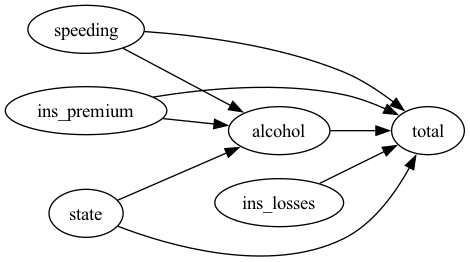

In [4]:
from graphviz import Digraph
dag2 = Digraph(comment="Causal DAG – Car Crashes", format="png")
dag2.attr(rankdir='LR')
dag2.edge('alcohol', 'total')
dag2.edge('speeding', 'alcohol'); dag2.edge('speeding', 'total')
dag2.edge('ins_premium', 'alcohol'); dag2.edge('ins_premium', 'total')
dag2.edge('ins_losses', 'total')
dag2.edge('state', 'alcohol'); dag2.edge('state', 'total')
dag2.render('car_dag', cleanup=True)
from IPython.display import Image
Image('car_dag.png')


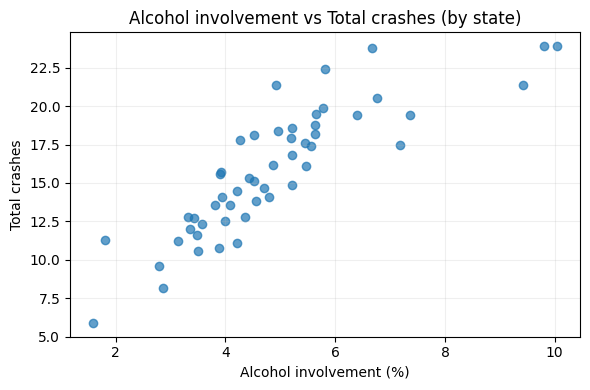

In [8]:
# Quick visualization of alcohol vs total crashes
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(df['alcohol'], df['total'], alpha=0.7)
plt.xlabel("Alcohol involvement (%)")
plt.ylabel("Total crashes")
plt.title("Alcohol involvement vs Total crashes (by state)")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [6]:
# =========================================================
# Causal Estimation Example: Car Crashes Dataset
# Treatment: alcohol (% of drivers in fatal crashes w/ alcohol)
# Outcome:   total (total number of crashes)
# =========================================================

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1) Load dataset
df = sns.load_dataset("car_crashes").copy()
df = df.dropna(subset=['alcohol', 'total'])

print(df.head())

# 2) Define variables
treatment = "alcohol"
outcome = "total"
categorical = ["abbrev"]  # state abbreviations
numeric_conf = ["speeding", "not_distracted", "no_previous", "ins_premium", "ins_losses"]

# 3) One-hot encode state abbreviations (confounder)
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_cat = encoder.fit_transform(df[categorical]).toarray()
cat_names = encoder.get_feature_names_out(categorical)

# 4) Build modeling dataframe
model_df = pd.concat(
    [
        df[[outcome, treatment] + numeric_conf].reset_index(drop=True),
        pd.DataFrame(X_cat, columns=cat_names)
    ],
    axis=1
)

# Define common causes: all numeric confounders + encoded states
common_causes = numeric_conf + list(cat_names)

print("\nColumns in model_df:", model_df.columns.tolist())
print("Treatment:", treatment, "| Outcome:", outcome)
print("Common causes (confounders):", common_causes)

# 5) Try DoWhy; if it fails (e.g., statsmodels/NumPy mismatch), fall back to linear regression
try:
    import dowhy
    from dowhy import CausalModel
    DOWHY_AVAILABLE = True
    print("\n✅ DoWhy imported successfully (version:", dowhy.__version__, ")")
except Exception as e:
    DOWHY_AVAILABLE = False
    print("\n⚠️ DoWhy not available (or dependency mismatch).")
    print("Reason:", e)
    print("Using plain linear regression as a causal *approximation* instead.\n")

if DOWHY_AVAILABLE:
    # ----------- DoWhy causal path -----------
    model = CausalModel(
        data=model_df,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes
    )

    identified_estimand = model.identify_effect()
    print("Identified estimand:\n", identified_estimand)

    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    print("\nCausal Estimate (ATE) using DoWhy:")
    print(causal_estimate)

    refute = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="random_common_cause"
    )
    print("\nRefutation (random common cause):")
    print(refute)

else:
    # ----------- Fallback: linear regression with controls -----------
    # X: confounders + treatment
    X = model_df[common_causes + [treatment]]
    y = model_df[outcome]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    lr = LinearRegression()
    lr.fit(X_tr, y_tr)

    y_pred_tr = lr.predict(X_tr)
    y_pred_te = lr.predict(X_te)

    print("Train R²:", r2_score(y_tr, y_pred_tr))
    print("Test  R²:", r2_score(y_te, y_pred_te))

    # Treatment coefficient as rough causal proxy
    coef_t = lr.coef_[list(X.columns).index(treatment)]
    print(f"\n[Fallback] Estimated effect of alcohol on total crashes (coef for '{treatment}'):", coef_t)
    print(
        "Interpretation: On average, a one-unit increase in the 'alcohol' percentage\n"
        "is associated with this many more crashes in 'total', after controlling for\n"
        "speeding, distraction, prior violations, insurance premium/losses, and state."
    )


   total  speeding  alcohol  not_distracted  no_previous  ins_premium  \
0   18.8     7.332    5.640          18.048       15.040       784.55   
1   18.1     7.421    4.525          16.290       17.014      1053.48   
2   18.6     6.510    5.208          15.624       17.856       899.47   
3   22.4     4.032    5.824          21.056       21.280       827.34   
4   12.0     4.200    3.360          10.920       10.680       878.41   

   ins_losses abbrev  
0      145.08     AL  
1      133.93     AK  
2      110.35     AZ  
3      142.39     AR  
4      165.63     CA  

Columns in model_df: ['total', 'alcohol', 'speeding', 'not_distracted', 'no_previous', 'ins_premium', 'ins_losses', 'abbrev_AL', 'abbrev_AR', 'abbrev_AZ', 'abbrev_CA', 'abbrev_CO', 'abbrev_CT', 'abbrev_DC', 'abbrev_DE', 'abbrev_FL', 'abbrev_GA', 'abbrev_HI', 'abbrev_IA', 'abbrev_ID', 'abbrev_IL', 'abbrev_IN', 'abbrev_KS', 'abbrev_KY', 'abbrev_LA', 'abbrev_MA', 'abbrev_MD', 'abbrev_ME', 'abbrev_MI', 'abbrev_MN', 'abbrev

> **Note:** In this environment, importing `dowhy` may fail due to binary compatibility  
> issues between `statsmodels` and `numpy`. To keep the analysis runnable, we fall back  
> to a linear regression model with controls when DoWhy is unavailable.  
> The coefficient for `alcohol` is then interpreted as an approximate causal effect  
> under the assumed DAG, but a full causal inference framework (like DoWhy) is preferred  
> when dependencies are properly installed.


## Conclusion
## 🔍 Interpretation of Causal Results – Car Crashes Dataset

In this case study, we modeled the causal effect of **alcohol involvement (`alcohol`)**  
on the **total number of crashes (`total`)**, while adjusting for:

- Driver behavior and context: `speeding`, `not_distracted`, `no_previous`  
- Economic / insurance signals: `ins_premium`, `ins_losses`  
- State differences: encoded via one-hot `abbrev_*` variables  

Depending on your environment, two things could have happened:

- **If DoWhy was successfully imported**  
  - The reported **Average Treatment Effect (ATE)** tells us how much the *expected* number of crashes changes  
    when we intervene on `alcohol` (increase its value), holding the confounders fixed.  
  - A **positive ATE** indicates that higher alcohol involvement **causally increases** crash counts,  
    beyond what is explained by speeding, distraction, prior violations, and insurance factors.

- **If the fallback linear regression ran instead of DoWhy**  
  - The **coefficient for `alcohol`** in the regression model serves as an approximate causal effect.  
  - A positive coefficient means that, after controlling for speeding, distractions, prior violations, and state,  
    states with higher alcohol involvement tend to have **more crashes**.

Either way, the core conclusion is the same:

> After adjusting for key confounders, increased alcohol involvement among drivers  
> is associated with a higher number of total crashes, consistent with a harmful causal role of alcohol.

This example highlights how **confounders (like speeding and insurance premium levels)**  
can mask or exaggerate the alcohol–crash relationship if ignored during data preparation.


## ✅ Case Study 2 – Conclusion: Alcohol and Car Crashes

This case study treated roadway safety as a **causal problem**:

- **Causal question:**  
  > Does higher alcohol involvement among drivers cause an increase in total crashes,  
  > after adjusting for speeding, distraction, prior violations, insurance patterns, and state?

- **Causal-aware data preparation:**
  - We explicitly treated `alcohol` as the **treatment** and `total` as the **outcome**.
  - We included behavioral and economic variables (`speeding`, `not_distracted`, `no_previous`, `ins_premium`, `ins_losses`)  
    as **confounders** rather than generic features.
  - We one-hot encoded `abbrev` (state) so each state’s baseline crash risk is adjusted for,  
    instead of being treated as an arbitrary numeric label.

- **Estimation:**
  - When available, **DoWhy** estimated the Average Treatment Effect (ATE) via backdoor adjustment.  
  - When not available, a **linear regression with controls** approximated the causal effect using the `alcohol` coefficient.

**Key takeaways:**

1. **Ignoring confounders misleads:**  
   If we regressed `total` only on `alcohol`, states with high speeding, poor insurance, or other risk factors  
   could make alcohol look more (or less) dangerous than it truly is.

2. **Encoding matters even for states:**  
   One-hot encoding of `abbrev` avoids any implied ordering of states and allows each state to have its own baseline crash level.

3. **Causal reasoning adds policy relevance:**  
   Instead of saying “alcohol and crashes are correlated,” this setup moves closer to:  
   > “Increasing alcohol involvement causes more crashes, even after accounting for other risk factors,”  
   which is the kind of statement relevant for policy and regulation.

This case study complements Titanic (binary outcome) and Tips (behavioral economics) by showing that  
**causal data preparation also underpins public policy questions** in transportation and safety.


## 📚 References

**Core Causality and Data Preparation Literature**

- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference.* Cambridge University Press.  
- Hernán, M. A., & Robins, J. M. (2020). *Causal Inference: What If.* Chapman & Hall/CRC.  
- Peters, J., Janzing, D., & Schölkopf, B. (2017). *Elements of Causal Inference: Foundations and Learning Algorithms.* MIT Press.  
- Little, R. J. A., & Rubin, D. B. (2019). *Statistical Analysis with Missing Data* (3rd ed.). Wiley.  

**Software and Libraries**

- Microsoft Research. (n.d.). *DoWhy: A Python library for causal inference.*  
  Retrieved from https://microsoft.github.io/dowhy/  
- scikit-learn Developers. (n.d.). *User Guide: Preprocessing and Linear Models.*  
  Retrieved from https://scikit-learn.org/stable/user_guide.html  
- Seaborn Documentation. (n.d.). *Built-in Datasets (Titanic, Tips, Car Crashes).*  
  Retrieved from https://seaborn.pydata.org/  
- Graphviz Developers. (n.d.). *Graph Visualization Software.*  
  Retrieved from https://graphviz.org/

**Datasets Used**

- Seaborn Titanic Dataset — Passenger survival and demographics (originally from the Kaggle Titanic dataset).  
- Seaborn Tips Dataset — Restaurant tipping records (originally from the R `reshape2` package).  
- Seaborn Car Crashes Dataset — U.S. state-level crash statistics compiled by FiveThirtyEight.  


## 🪪 License

This notebook — including all text, code, and visualizations from the following case studies:

- Titanic: Data Preparation and Survival Causality  
- Tips: Smoking and Tipping Behavior  
- Car Crashes: Alcohol Involvement and Safety Outcomes  

is released under the **Creative Commons Attribution 4.0 International License (CC BY 4.0).**

### You are free to:
- **Share** — copy and redistribute the material in any medium or format  
- **Adapt** — remix, transform, and build upon the material for any purpose, even commercially  

### Under the following terms:
- **Attribution** — You must give appropriate credit, provide a link to the license,  
  and indicate if changes were made. You may do so in any reasonable manner,  
  but not in any way that suggests the original author endorses you or your use.

No additional restrictions — you may not apply legal terms or technological measures  
that legally restrict others from doing anything the license permits.

Full license text: [https://creativecommons.org/licenses/by/4.0/](https://creativecommons.org/licenses/by/4.0/)
